# P&D ISSP 2023 - Base notebook
@Students: Edit everything you want!

Packages

In [2]:
import matplotlib
import soundfile
import os
import package.general as genfcns
import package.gui_utils as guifcns
matplotlib.style.use('default')  # <-- for notebooks: white figures background

# Root path (path to where you are storing this very notebook)
#  /!/  Adapt this to your system  /!/ 
ROOTPATH = 'C:/Users/uprub/Documents/PandD/pandd2023-base'

pathToSoundFiles = f'{ROOTPATH}/sound_files/'

# Parameters
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'speech2.wav'
]
noisefilenames = [
    pathToSoundFiles + 'Babble_noise1.wav'
]
signalDuration = 10     # [s]
muGSC = 0.1     # NLMS update constant for freq.-domain GSC

Build acoustic scenario and generate RIRs using GUI

In [33]:
# Launch GUI
guifcns.RIRg_GUI(
    exportFolder=f'{os.getcwd()}/rirs',
    outputRIRplot=False,
    distBwMics=10,  # [cm]
    fs=44100,
    t60=0,
    theme='SystemDefault',
)



[INVALID VALUE] Please enter a room dimension larger than 2 metres.
[INVALID VALUE] Please enter a room dimension larger than 2 metres.
Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 2 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250220_15h37m55s.pkl.gz", in folder
"c:\Users\uprub\Documents\PandD\pandd2023-base\rirs"


Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[np.float64(4.0), np.float64(1.9)]]
>> Field "audioIds": ['61']
>> Field "c": 340
>> Field "distBwMics": 0.01
>> Field "exportFolder": c:\Users\uprub\Documents\PandD\pandd2023-base/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]
>> Field "micsCoords": [[np.float64(8.05), np.float64(5.8999999999999995)], [np.float64(8.05), np.float64(5.91)]]
>> Field "micsIds": ['59', '60']
>> Field "nMicsPerArray": 5
>> Field "noiseCoords": []
>> Field "noiseIds": []
>> Field "numMics": 2
>> Field "rirLength": 22050
>> Field "roomDim": 10.0
>> Field "t60": 0.0
>> Field "theme": SystemDefault

In [34]:
from package.gui_utils import load_rirs

acousticScenario = load_rirs(path="C:/Users/uprub/Documents/PandD/pandd2023-base/rirs/rirs_20250220_15h37m55s.pkl.gz") # loads the data
roomDim = acousticScenario.roomDim # access the room dimension [m]
print(acousticScenario) # print out all parameters

Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[np.float64(4.0), np.float64(1.9)]]
>> Field "audioIds": ['61']
>> Field "c": 340
>> Field "distBwMics": 0.01
>> Field "exportFolder": c:\Users\uprub\Documents\PandD\pandd2023-base/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]
>> Field "micsCoords": [[np.float64(8.05), np.float64(5.8999999999999995)], [np.float64(8.05), np.float64(5.91)]]
>> Field "micsIds": ['59', '60']
>> Field "nMicsPerArray": 5
>> Field "noiseCoords": []
>> Field "noiseIds": []
>> Field "numMics": 2
>> Field "rirLength": 22050
>> Field "roomDim": 10.0
>> Field "t60": 0.0
>> Field "theme": SystemDefault



RIRs selection

Text(0.5, 1.0, 'RIR of source 1 to microphone 2')

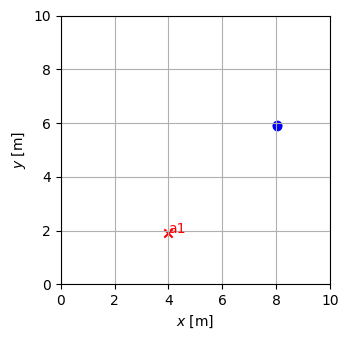

<Figure size 640x480 with 0 Axes>

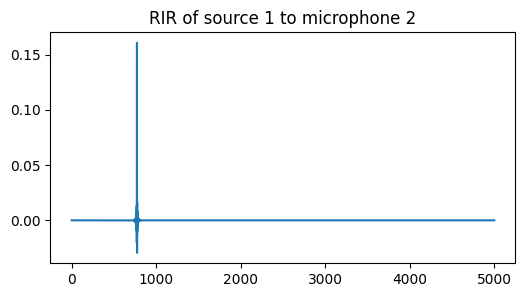

In [37]:
import matplotlib.pyplot as plt
# Select RIRs to be used
# rirFile = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
rirFile = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
# Load from Pickle archive
acousticScenario = guifcns.load_rirs(path=rirFile)
# >>> NB: the RIRs can be accessed as acousticScenario.RIRsAudio /or/ RIRsNoise
acousticScenario.plot_asc()  # show the acoustic scenario as a pl

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(acousticScenario.RIRsAudio[0:5000,1,0])
plt.title("RIR of source 1 to microphone 2")

# plt.figure()
# plt.figure(figsize=(6, 3))
# plt.plot(acousticScenario.RIRsNoise[:,0,0])
# print(acousticScenario.RIRsAudio.shape)
# print(acousticScenario)

# print(acousticScenario.RIRsAudio)
# print(acousticScenario.RIRsNoise.shape)
# print(acousticScenario)

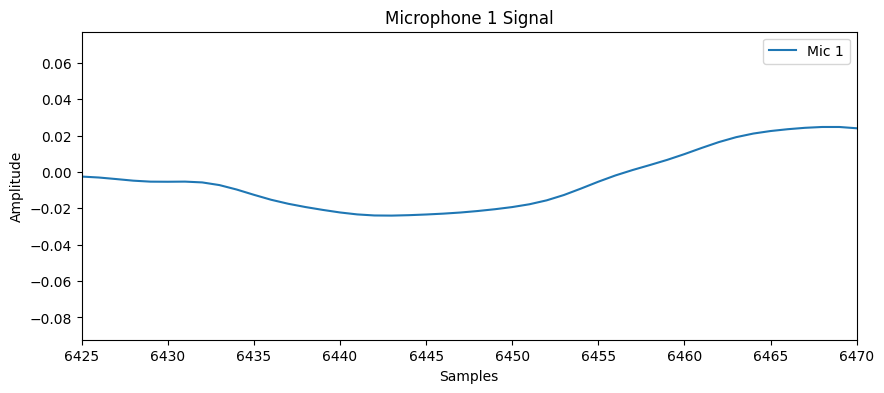

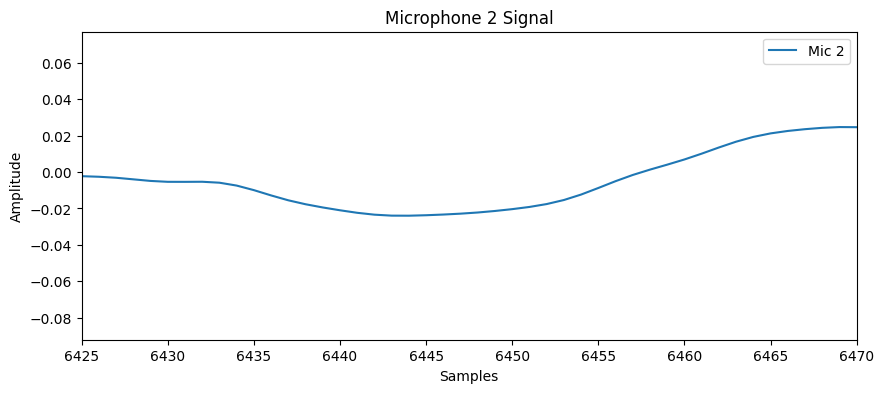

(220500, 2)


In [ ]:
# Part 2
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(target_audio_files, noise_audio_files, acousticScenario, T_s):
    num_micro = acousticScenario.RIRsAudio.shape[1]   # number of microphones
    # num_audio = acousticScenario.RIRsAudio.shape[2]   # number of audio sources
    # num_noise = acousticScenario.RIRsNoise.shape[2]   # number of noise sources

    fs = acousticScenario.fs
    T_ds = int(T_s * fs)

    # Load and resample target audio sources
    speech_components = []
    for file in target_audio_files:
        speech, fs_audio = sf.read(file)
        speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
        speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
        speech_components.append(speech_padded)
    
    # Load and resample noise sources
    noise_components = []
    for file in noise_audio_files:
        noise, fs_noise = sf.read(file)
        noise_resampled = signal.resample(noise, int(len(noise) * fs / fs_noise)) if fs != fs_noise else noise
        noise_padded = np.pad(noise_resampled[:T_ds], (0, max(0, T_ds - len(noise_resampled))))
        noise_components.append(noise_padded)

    mic_signals = np.zeros((T_ds, num_micro))
    for mic_idx in range(num_micro):
        mic_signal = np.zeros(T_ds)
        for audio_idx, speech in enumerate(speech_components):
            rir_speech = acousticScenario.RIRsAudio[:, mic_idx, audio_idx]
            mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')
        for noise_idx, noise in enumerate(noise_components):
            rir_noise = acousticScenario.RIRsNoise[:, mic_idx, noise_idx]
            mic_signal += signal.fftconvolve(noise, rir_noise, mode='same')

        mic_signals[:, mic_idx] = mic_signal
    
    # Plot first two microphone signals
    for mic_idx in range(num_micro):
        plt.figure(figsize=(10, 4))
        plt.plot(mic_signals[:, mic_idx], label=f'Mic {mic_idx + 1}')
        plt.title(f"Microphone {mic_idx + 1} Signal")
        # plt.xlim((6425,6470))
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()
    
    return mic_signals, speech_components, noise_components

Time_duration = 5
mic, speech, noise = create_micsigs(["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/speech1.wav"], [], acousticScenario, Time_duration)

# sd.play(speech1[0:fs*1], fs)
# sd.play(mic[:,0], fs)

print(mic.shape)
# Play the first microphone signal
sd.play(mic[:, 0], samplerate=acousticScenario.fs)
sd.wait()  # Wait until playback finishes

In [ ]:
#Part 3
import numpy as np
import scipy.signal as signal

def TDOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  rir1 = acousticScenario.RIRsAudio[:,0,0]
  rir2 = acousticScenario.RIRsAudio[:,1,0]

  direct_path_idx1 = np.argmax(np.abs(rir1))
  direct_path_idx2 = np.argmax(np.abs(rir2))

  ground_truth_TDOA = (direct_path_idx1 - direct_path_idx2) / acousticScenario.fs
  print(f"Ground truth TDOA: {ground_truth_TDOA:.6f} seconds")

  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:, 0] # Signal of the first mic
  mic2 = mic_signals[:, 1] # Signal of the second mic

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs
  print(f"Estimated TDOA: {estimated_TDOA:.6f} seconds")

  plt.figure(figsize=(8, 4))
  plt.plot(lags / acousticScenario.fs, cross_corr, label="Crosscorrelation")
  plt.stem([ground_truth_TDOA], [np.max(cross_corr)], linefmt="r-", markerfmt="ro", basefmt="r-", label="Groundtruth")
  plt.stem([estimated_TDOA], [np.max(cross_corr)], linefmt="g-", markerfmt="go", basefmt="g-", label="Estimated value")

  plt.xlabel("Time difference (seconden)")
  plt.ylabel("Crosscorrelation amplitude")
  plt.legend()
  plt.title("TDOA estimate via crosscorrelation")
  plt.xlim(-0.01, 0.01)
  plt.grid()
  plt.show()

  # Step 5: Print de fout tussen de schatting en de grondwaarheid
  error = np.abs(estimated_TDOA - ground_truth_TDOA)
  print(f"TDOA estimation error: {error:.6f} seconds")

TDOA_corr('F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav', 'F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav',"F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)

In [ ]:
#Part 4
def DOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:,0] # First mic signal
  mic2 = mic_signals[:,1] # Second mic signal

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  cross_corr /= np.max(np.abs(cross_corr))
  peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

  if len(peaks) < 2:
    raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")
  
  peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
  selected_peaks = peaks[peak_indices]

  TDOAestAll = []

  for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

  print(f"First estimated TDOA: {TDOAestAll[0]:.6f} seconds")
  print(f"Second estimated TDOA: {TDOAestAll[1]:.6f} seconds")

  c = 340 # Speed of sound in air (m/s)
  mic_distance = acousticScenario.distBwMics
  TDOAestAll = np.array(TDOAestAll)
  cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
  cos_theta = np.clip(cos_theta, -1, 1)
  DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

  print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")
  print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
  
  plt.figure(figsize=(8, 4))
  plt.plot(lags / fs, cross_corr, label="cross correlation")
  plt.axvline(x=estimated_TDOA, color='g', linestyle="--", label=f"TDOA: {estimated_TDOA:.6f}s")

  plt.xlabel("Time difference (seconds)")
  plt.ylabel("Cross correlation amplitude")
  plt.legend()
  plt.xlim(-0.01,0.01)
  plt.title("TDOA and DOA estimation via crosscorrelation")
  plt.grid()
  plt.show()
  

  DOAestAll = DOA_estimate
  DOAestAll = np.array(DOAestAll)
  return DOAestAll

DOAestALL = DOA_corr("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)
print(DOAestALL)

In [ ]:
# Part 5
def TDOA_corr_2(audio1_name, audio2_name, noise_name, acousticScenario, mic):
 first_source = 0
 second_source = 1
 rir1_1 = acousticScenario.RIRsAudio[:,first_source,0]
 rir2_1 = acousticScenario.RIRsAudio[:,second_source,0]

 direct_path_idx1_1 = np.argmax(np.abs(rir1_1))
 direct_path_idx2_1 = np.argmax(np.abs(rir2_1))

 ground_truth_TDOA_1 = (direct_path_idx1_1 - direct_path_idx2_1) / acousticScenario.fs

 print(f"Ground truth TDOA of source 1: {ground_truth_TDOA_1:.6f} seconds")

 rir1_2 = acousticScenario.RIRsAudio[:,first_source,1]
 rir2_2 = acousticScenario.RIRsAudio[:,second_source,1]

 direct_path_idx1_2 = np.argmax(np.abs(rir1_2))
 direct_path_idx2_2 = np.argmax(np.abs(rir2_2))

 ground_truth_TDOA_2 = (direct_path_idx1_2 - direct_path_idx2_2) / acousticScenario.fs

 print(f"Ground truth TDOA of source 2: {ground_truth_TDOA_2:.6f} seconds")

 mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

 mic1 = mic_signals[:, 0] # Signal of the first mic
 mic2 = mic_signals[:, 1] # Signal of the second mic

 cross_corr = signal.correlate(mic1, mic2, mode="full")
 lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

 cross_corr /= np.max(np.abs(cross_corr))
 peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

 if len(peaks) < 2:
  raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")

 # Select the two highest peaks
 peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
 selected_peaks = peaks[peak_indices]

 TDOAestAll = []

 for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

 estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs

 print(f"First estimated TDOA: {TDOAestAll[1]:.6f} seconds")
 print(f"Second estimated TDOA: {TDOAestAll[0]:.6f} seconds")

 c = 340 # Speed of sound in air (m/s)
 mic_distance = acousticScenario.distBwMics
 TDOAestAll = np.array(TDOAestAll)
 cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
 cos_theta = np.clip(cos_theta, -1, 1)
 DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

 print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
 print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")

TDOA_corr_2("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario, mic)


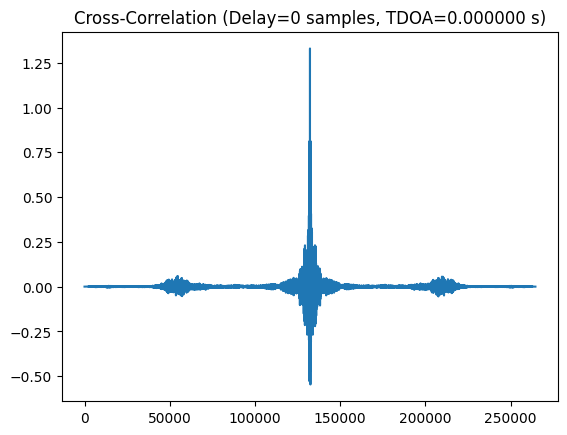

DOA estimate for HMIR_L1.wav & HMIR_L2.wav: 90.00°


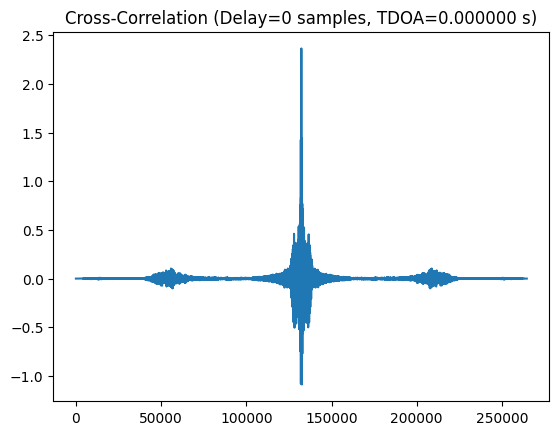

DOA estimate for HMIR_R1.wav & HMIR_R2.wav: 90.00°


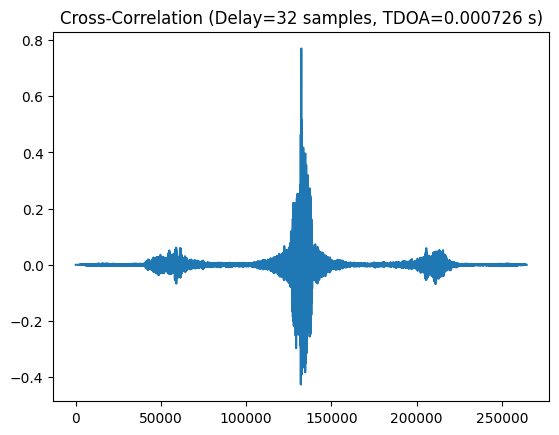

DOA estimate for HMIR_L1.wav & HMIR_R1.wav: 0.00°


In [ ]:
# Part 6
import numpy as np
import soundfile as sf
import scipy.signal as sig
import matplotlib.pyplot as plt
import os
import glob

def create_micsigs_2(rir_files, audio_file):
  # """Generates microphone signals from measured impulse responses."""
  rir_signals = [sf.read(f)[0] for f in rir_files]
  audio, fs_audio = sf.read(audio_file)

  # Ensure sampling rates match
  fs_rir = sf.read(rir_files[0])[1]

  T_ds = int(3*fs_rir)
  audio = audio[0:T_ds]

  if fs_audio != fs_rir:
    audio = sig.resample(audio, int(len(audio) * fs_rir / fs_audio))

  # Convolve with impulse response
  mic_signals = [sig.fftconvolve(audio, rir)[:len(audio)] for rir in rir_signals]

  return np.column_stack(mic_signals), fs_rir

def estimate_tdoa(mic1, mic2, fs):
  """Estimates the time difference of arrival (TDOA) using cross-correlation."""
  # corr = sig.correlate(mic1, mic2, mode='full')
  # delay = sig.correlation_lags(len(mic1),len(mic2), mode='full')
  # tdoa = delay[np.argmax(corr)] / fs
  corr = sig.correlate(mic1, mic2, mode='full')
  delay = np.argmax(corr) - (len(mic1) - 1)
  tdoa = delay / fs

  plt.figure()
  plt.plot(corr)
  plt.title(f"Cross-Correlation (Delay={delay} samples, TDOA={tdoa:.6f} s)")
  plt.show()

  return tdoa

def estimate_doa(tdoa, mic_spacing, c=340):
  """Converts TDOA into a DOA estimate."""
  # theta = np.arccos((tdoa * c) / mic_spacing) * (180 / np.pi)
  cos_theta = (tdoa * c) / mic_spacing
  cos_theta = np.clip(cos_theta, -1, 1)
  theta = np.arccos(cos_theta)*(180/np.pi)
  return theta

# Paths to impulse responses and target audio
rir_path = "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s30"
audio_file = "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\part1_track1_dry.wav"
mic_pairs = [("HMIR_L1.wav", "HMIR_L2.wav"), ("HMIR_R1.wav", "HMIR_R2.wav"), ("HMIR_L1.wav", "HMIR_R1.wav")]

# Process each microphone pair
for mic1_file, mic2_file in mic_pairs:
  mic_files = [os.path.join(rir_path, mic1_file), os.path.join(rir_path, mic2_file)]
  mic_signals, fs = create_micsigs_2(mic_files, audio_file)

  # Estimate TDOA
  tdoa = estimate_tdoa(mic_signals[:, 0], mic_signals[:, 1], fs)

  # Define microphone spacing (1.3 cm for same ear, 21.5 cm for opposite ears)
  # mic_spacing = 0.013 if "L1" in mic1_file and "L2" in mic2_file else 0.215
  mic_spacing = 0.215 if "L1" in mic1_file and "R1" in mic2_file else 0.013

  # Estimate DOA
  doa = estimate_doa(tdoa, mic_spacing)
  print(f"DOA estimate for {mic1_file} & {mic2_file}: {doa:.2f}°")






# Signal processing - Week 2: MUSIC algorithm

In [5]:
import numpy as np

winLength = 1024 # Window length
nSources = acousticScenario.RIRsAudio.shape[-1] +\
    acousticScenario.RIRsNoise.shape[-1] # Number of sources
theta = np.arange(0, np.pi, step=np.pi / 360)  # angles to consider

print('Computing DOAs via freq.-domain MUSIC algorithm...')


# DOAestAll = yourMUSIC() ...
DOAestAll = np.zeros(nSources)  # default


print(f'All estimated DOAs: {DOAestAll * 180/np.pi}')

# ------------------ DOA estimation performance check ------------------
# Oracle selection of the target DOA
DOAest, oracleDOAtalkers = genfcns.oracle_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Oracle-selected estimated DOAs: {DOAest * 180/np.pi}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
print(f'Target DOAs estimate error(s): {np.round((DOAest - oracleDOAtalkers) * 180/np.pi, 1)} deg.')

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
#frequency check
if acousticScenario.fs == 44100:
    print("Correct sampling frequency: 44.1 kHz")
else:
    raise ValueError(f"False: Incorrect sampling frequency, current sampling frequency {acousticScenario.fs} Hz")

In [ ]:
import numpy as np
from scipy.signal import stft

# Known parameters
fs = 44100         # Sampling rate
L = 1024           # STFT window length
hop = L // 2       # 50% overlap, corresponding to step size
M = mic.shape[1]   # Number of microphones, =5
n_samples = mic.shape[0]  # Total number of samples, =441000

# List to store the STFT results of each microphone
stft_mics_list = []

for m in range(M):
    # Extract the time-domain signal of the m-th microphone
    mic_signal = mic[:, m]
    
    # Calculate STFT
    f, t, Zxx = stft(mic_signal,
                     fs=fs,
                     window='hann',
                     nperseg=L,
                     noverlap=hop,
                     return_onesided=True)

    # Zxx shape is generally (nF, nT), where nF = L/2+1 (when return_onesided=True for real signals)
    stft_mics_list.append(Zxx)

# Stack the STFT results of all microphones into a 3D array with shape (M, nF, nT)
stft_mics = np.array(stft_mics_list)  # (M, nF, nT)

# stft_mics[m, :, :] is the STFT result of the m-th microphone
print("stft_mics shape:", stft_mics.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def music_narrowband(stft_mics, fs, d=0.05, c=343.0):
    """
    Use the narrowband MUSIC algorithm to estimate the DOA of a single sound source (0° ~ 180°).
    
    Parameters:
    stft_mics : ndarray of shape (M, nF, nT)
        STFT results of M microphones, 
        M: number of microphones, nF: number of frequency bins, nT: number of time frames.
    fs : float
        Sampling rate (Hz).
    d : float
        Microphone element distance (m).
    c : float
        Speed of sound (m/s).
        
    Returns:
    doa_estimate : float
        Estimated direction of arrival (DOA) of the sound source (°), in the range [0, 180].
    """
    M, nF, nT = stft_mics.shape
    
    # -------------------------------------------------------------------------
    # 1) Find the frequency bin with the highest energy
    #    Average the power of each frequency bin across all microphones and time frames
    # -------------------------------------------------------------------------
    # stft_mics shape is (M, nF, nT), first take the squared magnitude np.abs(...)**2, then
    # average over the M and nT dimensions => axis = (0, 2) => resulting shape = (nF,)
    power_per_bin = np.mean(np.abs(stft_mics)**2, axis=(0, 2))
    fidx = np.argmax(power_per_bin)  # Index of the frequency bin with the maximum energy
    
    # -------------------------------------------------------------------------
    # 2) Extract the signals from all microphones at this frequency point (M, nT)
    #    Denote as X(ω_max), where X is the narrowband signal in different time frames
    # -------------------------------------------------------------------------
    X_omega = stft_mics[:, fidx, :]  # shape => (M, nT)
    
    # -------------------------------------------------------------------------
    # 3) Estimate the spatial covariance matrix Rxx (M x M)
    #    In the case of a single source + noise, Rxx can be estimated by averaging over the time frames:
    #
    #       Rxx = (1 / nT) * Σ_{t=1 to nT} [x(t) x^H(t)]
    #
    #    where x(t) ∈ C^M is the complex-valued signal from the M microphones at time t
    # -------------------------------------------------------------------------
    # Note: X_omega[:, t] corresponds to the (M,) vector for the t-th frame
    # We can perform matrix multiplication all at once
    # X_omega has shape (M, nT), so X_omega @ X_omega^H => (M, M)
    # Need to take the complex conjugate transpose of X_omega before multiplying
    Rxx = (X_omega @ X_omega.conj().T) / nT  # (M, M)
    
    # -------------------------------------------------------------------------
    # 4) Perform eigenvalue decomposition of Rxx, distinguishing signal subspace from noise subspace
    #
    #    - For the single source case: 
    #      The largest eigenvalue corresponds to the signal subspace (1D), 
    #      and the remaining M-1 eigenvalues correspond to the noise subspace.
    #    - We typically only need the eigenvectors corresponding to the noise subspace U_n (M, M-1)
    # -------------------------------------------------------------------------
    eigenvals, eigenvecs = np.linalg.eig(Rxx)
    # Note: Eigenvalues and eigenvectors from np.linalg.eig are unordered and need to be sorted
    sort_indices = np.argsort(eigenvals)  # Sorting in ascending order
    eigenvals_sorted = eigenvals[sort_indices]
    eigenvecs_sorted = eigenvecs[:, sort_indices]
    
    # For a single source, the largest eigenvalue corresponds to the signal subspace,
    # and the smallest M-1 eigenvalues correspond to the noise subspace
    # Noise subspace eigenvectors:
    Un = eigenvecs_sorted[:, 0:M-1]  # (M, M-1)
    
    # -------------------------------------------------------------------------
    # 5) Loop through 0° ~ 180° (step size 0.5°) and calculate the MUSIC pseudospectrum
    #
    #    P(θ) = 1 / ( a^H(θ) * Un * Un^H * a(θ) )
    #
    #    where a(θ) is the steering vector of a plane wave incident from θ direction at this frequency
    #
    #    For a linear uniform array (ULA), the array coordinates can be set as the k-th microphone position 
    #    being (k-1)*d, and thus a(θ) = [1, e^{-j k0 * Δ}, e^{-j k0 * 2Δ}, ..., e^{-j k0 * (M-1)Δ}]^T
    #    where k0 = 2π * f_bin / c, and Δ = d * sin(θ)
    #
    #    If you want 0° to represent alignment with the array, the common assumption is:
    #       The incident angle θ is the angle with respect to the array’s perpendicular direction
    #       a(θ) = exp( -j * k0 * (0, 1, 2, ..., M-1)^T * d * sin(θ) )
    #
    # -------------------------------------------------------------------------
    theta_vals = np.arange(0, 180.5, 0.5)  # 0°, 0.5°, 1.0°, ..., 180°
    
    # (a) First calculate the actual frequency (Hz) corresponding to this frequency bin
    #     For better accuracy, you could directly use f[fidx] from the original stft(...) return value
    #     Here we use the formula approximation: f_bin = (fidx / nF) * (fs/2)
    #     If you retained f from the stft result, use f[fidx] for better accuracy
    f_bin = (fidx / (nF - 1)) * (fs / 2)
    # Wavenumber k0 = 2π f_bin / c
    k0 = 2 * np.pi * f_bin / c
    
    P_music = []
    
    # To reduce the for loop, we often still need a loop for θ, 
    # but we try to vectorize within it. Below is an intuitive implementation:
    for theta_deg in theta_vals:
        theta = np.deg2rad(theta_deg)  # Convert to radians
        # Steering vector a(θ): shape (M,)
        # m=0,1,...,M-1 => phase difference = -k0 * m * d * sin(θ)
        m_index = np.arange(M)
        steer = np.exp(-1j * k0 * m_index * d * np.cos(theta))  # (M,)
        
        # Calculate a^H * Un * Un^H * a
        # First compute v = Un^H * a => (M-1,)
        v = Un.conj().T @ steer  
        # Then compute v^H * v => complex scalar
        denom = np.abs(v @ v.conj())  # Can also write as (v.conj().T @ v).real
        
        pseudospec = 1.0 / denom
        P_music.append(pseudospec)
    
    P_music = np.array(P_music)  # shape (len(theta_vals),)
    
    # -------------------------------------------------------------------------
    # 6) Plot the MUSIC pseudospectrum
    # -------------------------------------------------------------------------
    plt.figure(figsize=(8, 4))
    plt.plot(theta_vals, 10 * np.log10(P_music), 'b-')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Pseudospectrum (dB)')
    plt.title('Narrowband MUSIC Pseudospectrum')
    plt.grid(True)
    
    # -------------------------------------------------------------------------
    # 7) Find the DOA corresponding to the maximum peak
    # -------------------------------------------------------------------------
    doa_index = np.argmax(P_music)
    doa_estimate = theta_vals[doa_index]  # For a single source, this is the location of the global maximum
    
    # Mark on the plot
    plt.stem([doa_estimate], [10 * np.log10(P_music[doa_index])], 
             linefmt='r--', markerfmt='ro', basefmt=" ")
    plt.text(doa_estimate + 1, 10*np.log10(P_music[doa_index]), 
             f"DOA={doa_estimate:.1f}°", color='red')
    
    plt.tight_layout()
    plt.show()
    
    return doa_estimate

doa_estimate = music_narrowband(stft_mics, acousticScenario.fs, d=0.05, c=340)
print(doa_estimate)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_narrowband_multisource(stft_mics, fs, Q, d=0.05, c=343.0):
    """
    Use the narrowband MUSIC algorithm to estimate the DOA of multiple (Q) sources, suitable for linear arrays (ULA).
    
    Parameters:
    --------
    stft_mics : ndarray, shape (M, nF, nT)
        The STFT results from M microphones:
          - M: Number of microphones
          - nF: Number of frequency bins
          - nT: Number of time frames
    fs : float
        Sampling rate (Hz).
    Q : int
        Number of target sources (known).
    d : float
        Distance between adjacent microphone elements (m).
    c : float
        Speed of sound (m/s).
        
    Returns:
    --------
    doa_estimates : ndarray, shape (Q,)
        The estimated Q DOAs (in degrees), possibly unordered, can be sorted.
    """
    
    M, nF, nT = stft_mics.shape
    
    # -------------------------------------------------------------------------
    # 1) Find the frequency bin with the maximum energy (same as single-source version)
    # -------------------------------------------------------------------------
    power_per_bin = np.mean(np.abs(stft_mics)**2, axis=(0, 2))  # shape = (nF,)
    # If the DC bin has too much power, manually set it to zero to avoid interference
    power_per_bin[0] = 0  # Avoid selecting the DC bin
    
    fidx = np.argmax(power_per_bin)  # Index of the frequency bin with the strongest energy
    
    # You can also use the actual frequency array f returned by STFT to take f_bin = f[fidx]
    # Here is an approximate formula:
    f_bin = (fidx / (nF - 1)) * (fs / 2)
    
    # -------------------------------------------------------------------------
    # 2) Extract data at the strongest frequency bin from all microphones and time frames => used to compute spatial covariance Rxx
    # -------------------------------------------------------------------------
    X_omega = stft_mics[:, fidx, :]  # shape = (M, nT)
    Rxx = (X_omega @ X_omega.conj().T) / nT  # (M, M)
    
    # -------------------------------------------------------------------------
    # 3) Eigenvalue decomposition to distinguish the (Q) signal subspace and (M - Q) noise subspace
    # -------------------------------------------------------------------------
    eigenvals, eigenvecs = np.linalg.eig(Rxx)
    sort_idx = np.argsort(eigenvals)       # From smallest to largest
    eigenvals_sorted = eigenvals[sort_idx]
    eigenvecs_sorted = eigenvecs[:, sort_idx]
    
    # The noise subspace corresponds to the smallest (M - Q) eigenvalues
    Un = eigenvecs_sorted[:, :M - Q]  # shape (M, M-Q)
    
    # -------------------------------------------------------------------------
    # 4) Iterate over angles θ = 0°~180°, step 0.5°, calculate the MUSIC pseudospectrum
    #    P(θ) = 1 / ( a^H(θ)*Un*Un^H*a(θ) )
    # -------------------------------------------------------------------------
    theta_vals = np.arange(0, 180.5, 0.5)
    k0 = 2 * np.pi * f_bin / c  # Wavenumber
    P_music = []
    
    m_index = np.arange(M)  # Corresponding microphone indices 0,1,2,...,M-1
    
    for theta_deg in theta_vals:
        theta_rad = np.deg2rad(theta_deg)
        # If 0° is defined at the end-fire direction (along the array), use cos(θ)
        # If 0° is defined at the broadside (perpendicular array), use sin(θ)
        # The problem tends to define "0°=top end-fire", so use cos(θ):
        steer = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))  # (M,)
        
        v = Un.conj().T @ steer  # shape = (M-Q,)
        denom = np.abs(v @ v.conj())
        pseudospec = 1.0 / denom
        P_music.append(pseudospec)
        
    P_music = np.array(P_music)  # shape (len(theta_vals),)
    
    # -------------------------------------------------------------------------
    # 5) Find the Q largest peaks in the pseudospectrum, corresponding to the Q source locations
    # -------------------------------------------------------------------------
    # A simple method: directly take the Q largest points in P_music (may need to remove duplicates / non-adjacent peaks)
    # peak_indices = np.argsort(P_music)[-Q:]   # Take the last Q (largest Q)
    # peak_indices = peak_indices[::-1]         # From largest to smallest
    
    # doa_estimates = theta_vals[peak_indices]  # Angles (°), possibly unordered
    peaks, _ = find_peaks(P_music, distance=5, prominence=0.1)
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])  # No peaks found
    else:
        # Take the Q largest by amplitude
        peak_values_all = P_music[peaks]
        if len(peaks) < Q:
            # If fewer peaks than Q, return all peaks
            topQ_idx = np.argsort(peak_values_all)[::-1]  # From largest to smallest
        else:
            topQ_idx = np.argsort(peak_values_all)[-Q:]   # Take the largest Q
        # Sort (optional)
        topQ_idx_sorted = topQ_idx[np.argsort(peak_values_all[topQ_idx])]  
        
        peak_indices = peaks[topQ_idx_sorted]
        doa_estimates = theta_vals[peak_indices]
    
    # -------------------------------------------------------------------------
    # 6) Visualization: Plot the pseudospectrum and mark the Q peaks
    # -------------------------------------------------------------------------
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(P_music), 'b-', label='MUSIC pseudospectrum')
    
    # Mark the Q peaks on the plot
    for i, idx in enumerate(peak_indices):
        peak_angle = theta_vals[idx]
        peak_value = 10*np.log10(P_music[idx])
        plt.stem([peak_angle], [peak_value], linefmt='r--', markerfmt='ro', basefmt=" ")
        plt.text(peak_angle+0.5, peak_value, f"{peak_angle:.1f}°", color='red')
    
    plt.title(f"MUSIC (Q={Q} sources) @ freq bin={fidx}, f={f_bin:.1f} Hz")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Pseudospectrum (dB)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

doa_estimates = music_narrowband_multisource(stft_mics, acousticScenario.fs, acousticScenario.RIRsAudio.shape[2], d=0.05, c=340)
print(doa_estimates)
